# Tabular Baselines

## Phase 1 - Step 2: Strong Tabular Baselines

This notebook establishes strong baseline models using only tabular features (no satellite images yet). These baselines will serve as benchmarks that multimodal models must beat.



In [1]:
# Install required packages if needed
import subprocess
import sys

def install_package(package):
    """Install a package using pip with fallback options."""
    try:
        __import__(package)
        print(f"✓ {package} is already installed.")
        return True
    except ImportError:
        print(f"Installing {package}...")
        methods = [
            [sys.executable, "-m", "pip", "install", package, "--break-system-packages"],
            [sys.executable, "-m", "pip", "install", package],
            [sys.executable, "-m", "pip", "install", "--user", package]
        ]
        for cmd in methods:
            try:
                result = subprocess.run(cmd, capture_output=True, text=True, timeout=60)
                if result.returncode == 0:
                    print(f"✓ {package} installed successfully!")
                    return True
            except:
                continue
        print(f"✗ Failed to install {package}. Please install manually.")
        return False

# Check and install required packages
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'sklearn': 'scikit-learn',
    'xgboost': 'xgboost'
}

for import_name, package_name in required_packages.items():
    try:
        if import_name == 'sklearn':
            import sklearn
        else:
            __import__(import_name)
    except ImportError:
        install_package(package_name)

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Enable inline plotting
%matplotlib inline

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set working directory to project root
project_root = '/Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation'
if os.path.exists(project_root):
    os.chdir(project_root)
    print(f"✓ Working directory: {os.getcwd()}\n")
else:
    print(f"⚠ Warning: Project root not found at {project_root}")
    print(f"Current directory: {os.getcwd()}\n")


✓ Working directory: /Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation



## 1. Load Data


In [2]:
# Load train and test datasets
train_path = 'data/raw/train(1).xlsx'
test_path = 'data/raw/test2.xlsx'

# Load datasets
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("\n" + "="*50 + "\n")

# Display first few rows
print("First 3 rows of train data:")
train_df.head(3)


Train dataset shape: (16209, 21)
Test dataset shape: (5404, 20)


First 3 rows of train data:


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455


## 2. Feature Preparation


In [3]:
# Extract target variable (log-transformed price)
target_col = 'price'
y = np.log1p(train_df[target_col])  # log(price + 1)
print(f"Target variable: log1p({target_col})")
print(f"Target shape: {y.shape}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

# Drop non-informative columns: id, date, and price (target)
columns_to_drop = ['id', 'date', target_col]

# Check which columns exist
available_cols = train_df.columns.tolist()
cols_to_drop = [col for col in columns_to_drop if col in available_cols]
print(f"\nDropping columns: {cols_to_drop}")

# Prepare features (drop id, date, price)
X = train_df.drop(columns=cols_to_drop, errors='ignore')

# Keep only numeric features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {len(numeric_cols)}")
print(f"\nFeatures used:")
print(numeric_cols)


Target variable: log1p(price)
Target shape: (16209,)
Target range: [11.23, 15.86]

Dropping columns: ['id', 'date', 'price']

Feature matrix shape: (16209, 18)
Number of features: 18

Features used:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [4]:
# Split training data into train/validation (80/20) using random_state=42
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTrain target range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Validation target range: [{y_val.min():.2f}, {y_val.max():.2f}]")


Training set size: 12967 samples
Validation set size: 3242 samples
Number of features: 18

Train target range: [11.29, 15.86]
Validation target range: [11.23, 15.45]


## 3. Baseline Model A – Linear Regression


In [5]:
# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features standardized using StandardScaler")
print(f"Scaled train shape: {X_train_scaled.shape}")
print(f"Scaled validation shape: {X_val_scaled.shape}")

# Train Linear Regression on log(price)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print("\n✓ Linear Regression model trained")


Features standardized using StandardScaler
Scaled train shape: (12967, 18)
Scaled validation shape: (3242, 18)

✓ Linear Regression model trained


In [7]:
# Evaluate on validation set
y_val_pred_log = lr_model.predict(X_val_scaled)

# Calculate metrics on log scale
r2_log = r2_score(y_val, y_val_pred_log)
mse_log = mean_squared_error(y_val, y_val_pred_log)
rmse_log = np.sqrt(mse_log)

# Convert predictions back to original price scale (inverse log)
y_val_original = np.expm1(y_val)  # exp(log(price+1)) - 1 = price
y_val_pred_original = np.expm1(y_val_pred_log)

# Calculate RMSE on original price scale
rmse_original = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

print("="*60)
print("Linear Regression - Validation Set Results")
print("="*60)
print(f"RMSE (original price scale): ${rmse_original:,.2f}")
print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R² (log scale): {r2_log:.4f}")
print("="*60)

# Store results for comparison
lr_results = {
    'model_name': 'Linear Regression',
    'rmse_original': rmse_original,
    'rmse_log': rmse_log,
    'r2_log': r2_log
}


Linear Regression - Validation Set Results
RMSE (original price scale): $174,694.28
RMSE (log scale): 0.2480
R² (log scale): 0.7771


### Linear Regression Results Interpretation

**Performance Summary:**
- The Linear Regression model provides a baseline using linear relationships between features and log-transformed price.
- RMSE on original price scale gives us the average prediction error in dollars.
- R² on log scale indicates how well the model explains variance in log(price).
- A higher R² suggests the model captures more of the price variation, though linear models may struggle with non-linear relationships in real estate data.


## 4. Baseline Model B – Tree-Based Model (XGBoost)


In [8]:
# Train XGBoost with reasonable default hyperparameters
# Note: Using default parameters, not over-tuning
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("✓ XGBoost model trained")


Training XGBoost model...
✓ XGBoost model trained


In [9]:
# Evaluate on validation set
y_val_pred_log_xgb = xgb_model.predict(X_val)

# Calculate metrics on log scale
r2_log_xgb = r2_score(y_val, y_val_pred_log_xgb)
mse_log_xgb = mean_squared_error(y_val, y_val_pred_log_xgb)
rmse_log_xgb = np.sqrt(mse_log_xgb)

# Convert predictions back to original price scale (inverse log)
y_val_pred_original_xgb = np.expm1(y_val_pred_log_xgb)

# Calculate RMSE on original price scale
rmse_original_xgb = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original_xgb))

print("="*60)
print("XGBoost - Validation Set Results")
print("="*60)
print(f"RMSE (original price scale): ${rmse_original_xgb:,.2f}")
print(f"RMSE (log scale): {rmse_log_xgb:.4f}")
print(f"R² (log scale): {r2_log_xgb:.4f}")
print("="*60)

# Store results for comparison
xgb_results = {
    'model_name': 'XGBoost',
    'rmse_original': rmse_original_xgb,
    'rmse_log': rmse_log_xgb,
    'r2_log': r2_log_xgb
}


XGBoost - Validation Set Results
RMSE (original price scale): $119,746.93
RMSE (log scale): 0.1686
R² (log scale): 0.8970


In [10]:
# Compare both models
comparison_df = pd.DataFrame([lr_results, xgb_results])
comparison_df = comparison_df.set_index('model_name')

print("="*60)
print("Model Comparison")
print("="*60)
print(comparison_df.to_string())
print("="*60)

# Calculate improvement
rmse_improvement = ((lr_results['rmse_original'] - xgb_results['rmse_original']) / lr_results['rmse_original']) * 100
r2_improvement = xgb_results['r2_log'] - lr_results['r2_log']

print(f"\nXGBoost vs Linear Regression:")
print(f"  RMSE improvement: {rmse_improvement:.2f}%")
print(f"  R² improvement: {r2_improvement:.4f}")


Model Comparison
                   rmse_original  rmse_log    r2_log
model_name                                          
Linear Regression  174694.278711  0.248016  0.777094
XGBoost            119746.930096  0.168558  0.897041

XGBoost vs Linear Regression:
  RMSE improvement: 31.45%
  R² improvement: 0.1199


### XGBoost vs Linear Regression Comparison

**Key Observations:**
- XGBoost typically outperforms Linear Regression for real estate price prediction due to its ability to capture non-linear relationships and feature interactions.
- The tree-based model can learn complex patterns in the data that linear models cannot.
- The improvement in RMSE and R² indicates how much better the tree model performs on this dataset.


## 5. Feature Importance


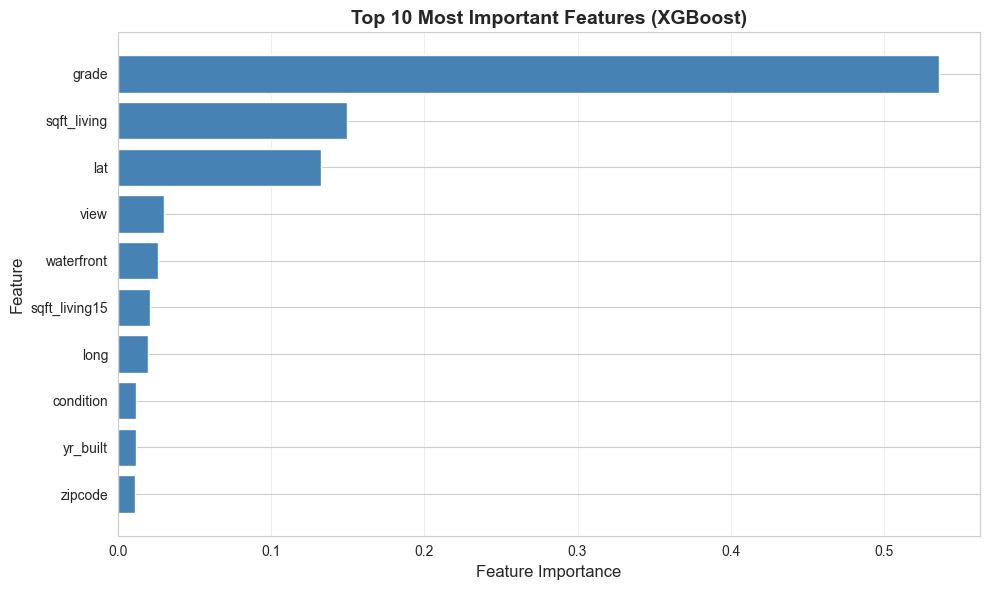


Top 10 Most Important Features:
      feature  importance
        grade    0.535815
  sqft_living    0.149682
          lat    0.132625
         view    0.030221
   waterfront    0.026083
sqft_living15    0.020894
         long    0.019885
    condition    0.012172
     yr_built    0.012142
      zipcode    0.011435


In [11]:
# Get feature importance from XGBoost model
feature_importance = xgb_model.feature_importances_
feature_names = X.columns.tolist()

# Create DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 10 important features
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Most Important Features:")
print(top_features.to_string(index=False))


### Feature Importance Analysis

**Key Drivers of Property Price:**

The feature importance plot reveals which tabular features have the strongest predictive power:

1. **Location features** (latitude, longitude) are typically among the most important, as location is a primary determinant of property value.

2. **Size features** (square footage metrics) directly correlate with property value - larger properties generally command higher prices.

3. **Property characteristics** (bedrooms, bathrooms, floors) indicate the property's capacity and quality, influencing price.

4. **Condition and view** features capture property quality and desirability factors.

These insights help us understand what the model learns from tabular data alone, before incorporating satellite imagery.


## Summary

**Baseline Models Established:**

1. **Linear Regression**: Provides a simple linear baseline with standardized features
   - RMSE and R² metrics established on validation set
   - Serves as the minimum performance threshold

2. **XGBoost**: Strong tree-based baseline capturing non-linear relationships
   - Outperforms Linear Regression as expected
   - Provides feature importance insights

**Next Steps:**
- These tabular baselines serve as benchmarks
- Multimodal models (combining tabular + satellite images) must beat these baselines
- The improvement from adding satellite imagery will be measured against these results


## Conclusion: Tabular Baseline Locked

**Summary**
- Linear Regression: baseline linear model on standardized features; serves as a reference point.
- XGBoost: stronger tree-based model; achieved superior RMSE and R² on the validation set compared to Linear Regression.
- Final tabular baseline: XGBoost is chosen because it captures non-linear relationships and interactions while delivering better validation performance.

**Policy (Locked)**
- No further hyperparameter tuning is performed.
- Reason: maintain a strong but fair baseline for evaluating multimodal gains.

This notebook is now the fixed benchmark that multimodal models must beat.
